# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

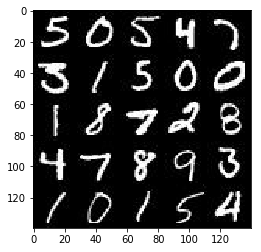

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

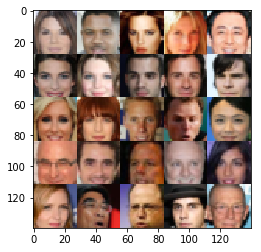

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        ## 28x28x32
        
        #x12 = tf.layers.conv2d(relu1, 64, 4, strides=2, padding='same')
        #bn12 = tf.layers.batch_normalization(x12, training=True)
        #relu12 = tf.maximum(alpha * bn12, bn12)
        
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 7x7x256
        
        x4 = tf.layers.conv2d(relu3, 512, 4, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # 7x7x512
        
        flat = tf.reshape(relu4, (-1, 7*7*512)) 
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected
        x1 = tf.layers.dense(z, (7*7*512))
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) # reshape to start the conv
        # bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1) #leaky relu

        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2) #leaky relu
        
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3) #leaky relu
        
        # 14x14x128
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 4, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4) #leaky relu

        # 14x14x64
        
        x5 = tf.layers.conv2d_transpose(relu4, 32, 4, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=is_train)
        relu5 = tf.maximum(alpha * bn5, bn5) #leaky relu
        
        # 28x28x32
        
        logits = tf.layers.conv2d_transpose(relu5, out_channel_dim, 4, strides=1, padding='same')
        
        # 28x28x3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.85))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]

    # optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    img_channels = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[1], img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                # random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 5 == 0:
                    # get train losses and print
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.0205... Generator Loss: 0.0709
Epoch 1/2... Discriminator Loss: 3.0700... Generator Loss: 0.1523
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 2.7279... Generator Loss: 0.1993
Epoch 1/2... Discriminator Loss: 2.8888... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 5.5182... Generator Loss: 0.0160
Epoch 1/2... Discriminator Loss: 2.2829... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 2.9133
Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 2.9068
Epoch 1/2... Discriminator Loss: 2.1691... Generator Loss: 0.4176
Epoch 1/2... Discriminator Loss: 1.6204... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.3717
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 3.2112
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 2.0890
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 1.3965
Epoch 1/2.

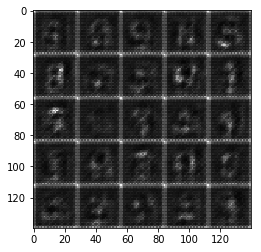

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.7139
Epoch 1/2... Discriminator Loss: 1.7658... Generator Loss: 0.4111
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 2.0710
Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 1.7569... Generator Loss: 3.8498
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 2.3344
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.8185
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 2.9000
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 1.0233
Epoch 1/2.

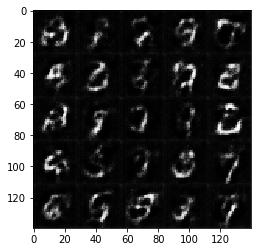

Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 2.1823
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 2.9482
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 2.5763
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 1.4326
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.9517
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 3.0794
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.2001
Epoch 1/2.

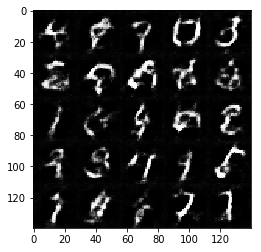

Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 2.3985
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.7372
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 1.6005... Generator Loss: 3.2683
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.9727
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 2.5346
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 1.7624
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 2.2854
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 0.8344
Epoch 1/2.

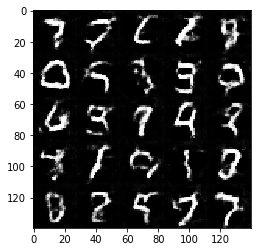

Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 2.1486... Generator Loss: 3.5509
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.4562
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 2.0511
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.7972
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 2.0854... Generator Loss: 3.3991
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 1.8631
Epoch 2/2.

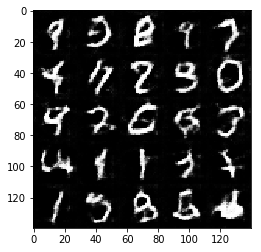

Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 3.1668
Epoch 2/2... Discriminator Loss: 2.4061... Generator Loss: 0.2385
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 1.5497
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.6351
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 2.1444
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 2.1630
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.5763... Generator Loss: 2.9652
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 2.2584
Epoch 2/2... Discriminator Loss: 1.1073... Generator Loss: 1.1329
Epoch 2/2.

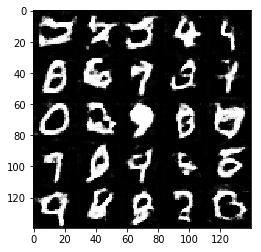

Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 2.7650
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 1.2886
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.2998
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 1.9070... Generator Loss: 3.4748
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 1.2735
Epoch 2/2.

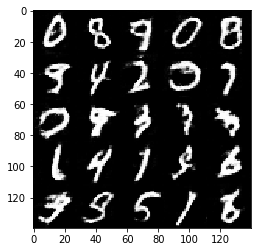

Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 2.5966
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.5349
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 1.4865
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 1.8651
Epoch 2/2... Discriminator Loss: 1.8589... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.0277
Epoch 2/2.

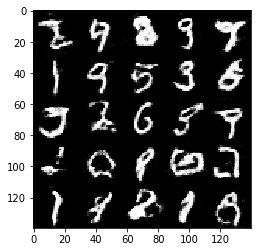

Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.7171
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.7918
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 1.3135
Epoch 2/2... Discriminator Loss: 1.5797... Generator Loss: 0.4937
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.3114
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.5586
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 1.4512
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.8461
Epoch 2/2.

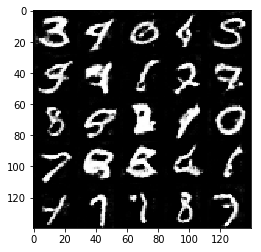

Epoch 2/2... Discriminator Loss: 1.5873... Generator Loss: 3.1216
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.8162


In [35]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8089... Generator Loss: 0.1662
Epoch 1/1... Discriminator Loss: 3.4027... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 2.4751
Epoch 1/1... Discriminator Loss: 4.2488... Generator Loss: 0.0611
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 11.9971
Epoch 1/1... Discriminator Loss: 1.8703... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 2.7251... Generator Loss: 18.8815
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 14.5005
Epoch 1/1... Discriminator Loss: 2.3023... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 9.0847
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 2.9049
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 4.6571
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 2.8133
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 4.8228
Epoch 1

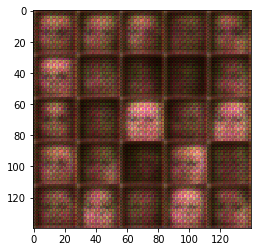

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 2.1385... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 4.0053
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 2.0339
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 3.1702
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.6749
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 2.1266... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.6504
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 2.1217
Epoch 1/1.

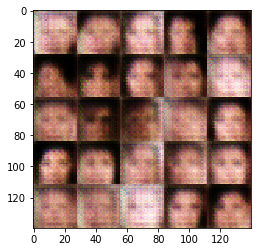

Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 3.6812
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 2.5338
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.3807
Epoch 1/1.

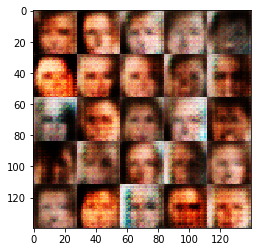

Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 2.0761
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 3.2258
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.5258
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.6243
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9206
Epoch 1/1.

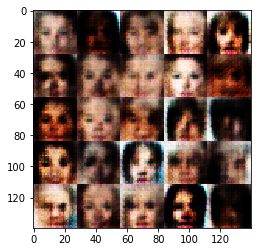

Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 3.2850
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 2.5507
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 2.9976
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.9789
Epoch 1/1.

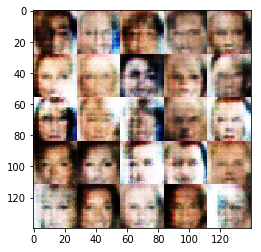

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 2.1746
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1932
Epoch 1/1.

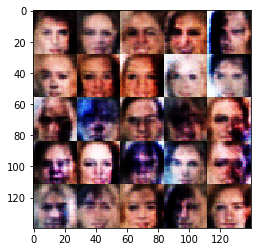

Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 3.8347
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.8144
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 3.6028
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 3.5772
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 2.5658
Epoch 1/1.

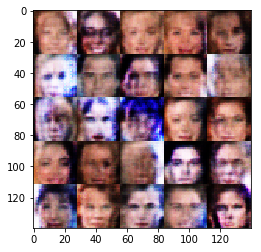

Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 2.5102
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.6965
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 2.9502
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 3.6990
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.7460
Epoch 1/1... Discriminator Loss: 2.1480... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.9123... Generator Loss: 0.3250
Epoch 1/1.

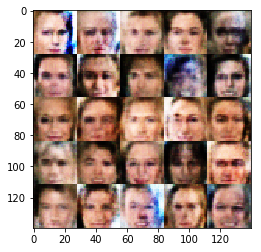

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 4.4704
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 2.8197
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 2.7052
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.7395
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 4.7987
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.7632... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 3.1345
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 2.4248
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 4.3345
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.6646
Epoch 1/1.

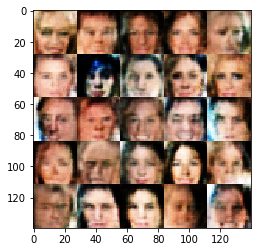

Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 2.6979
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 3.4821
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 2.3866
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 3.1576
Epoch 1/1... Discriminator Loss: 3.2347... Generator Loss: 7.8862
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 2.6816
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.9698
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 2.2757
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 2.1183
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 5.0748
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.6471
Epoch 1/1.

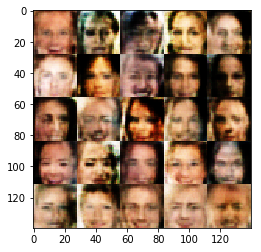

Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 2.1837
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 6.9175
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 3.7096
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.7104
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 2.6612
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 3.4216
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 5.0669
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.7175
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.4703
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 3.2568
Epoch 1/1.

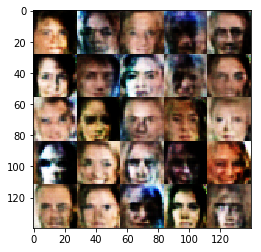

Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 5.3731
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 4.6194
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 2.2615
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 5.6093
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 4.7180
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 2.9291
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.0723
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 7.0024
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 4.0596
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 2.8274
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 4.9140
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 4.6900
Epoch 1/1.

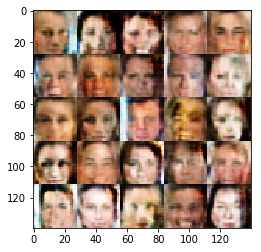

Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.9573
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 2.8338
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.6754
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 4.4620
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 3.7234
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 4.1301
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 4.0550
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 2.7740
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 3.6787
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.3828
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 3.1965
Epoch 1/1.

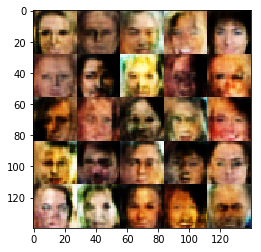

Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 2.1799
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 4.7394
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 3.1783
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 2.7214
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 4.1178
Epoch 1/1... Discriminator Loss: 3.7706... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 2.5378
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 3.0670
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 2.9658
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8137
Epoch 1/1.

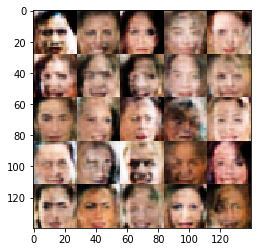

Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 2.9982
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 3.4669
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 3.2776
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 2.8404
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 2.9219
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 2.9355
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 4.5281
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 3.7943
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.6658
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 3.8994
Epoch 1/1.

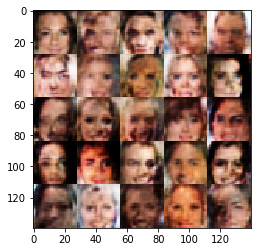

Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 3.0071
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 2.9040
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 2.5389
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 2.4002
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 3.4666
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 2.5718
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 3.1961
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 3.1239
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.6975
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 2.4858
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.4235
Epoch 1/1.

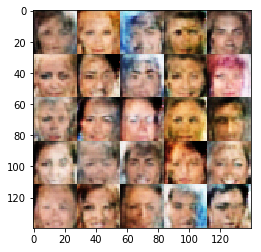

Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.6118
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 2.6430
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 4.0980
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 4.4150
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 2.1070... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 2.7347
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 2.3526
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 3.5763
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 2.4284
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.2963
Epoch 1/1.

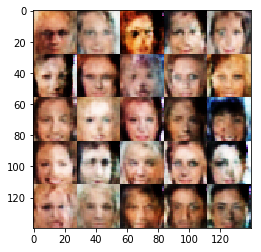

Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 3.9563
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 3.1675
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 3.3185
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.8441
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 3.4900
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 4.3198
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.7552
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 3.8388
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 3.2602
Epoch 1/1.

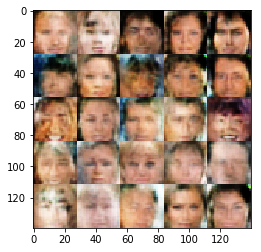

Epoch 1/1... Discriminator Loss: 2.5891... Generator Loss: 4.4602
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 2.0550
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 3.3609
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 6.1693
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 3.8514
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 4.3397
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 2.7723
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 3.3622
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 3.7786
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 2.9151
Epoch 1/1.

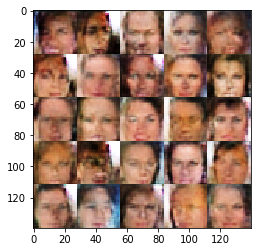

Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.6513
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 3.4470
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 5.4213
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 3.9936
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 2.4358
Epoch 1/1... Discriminator Loss: 2.7047... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 3.7696
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 2.9369
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.8760
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.9728
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 3.4788
Epoch 1/1.

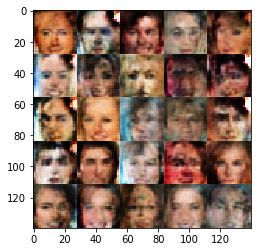

Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 3.0968
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 3.2411
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 5.0752
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.9805
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 2.3698
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.6036
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 3.6140
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 3.2948
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 2.9031... Generator Loss: 5.2142
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.3059
Epoch 1/1.

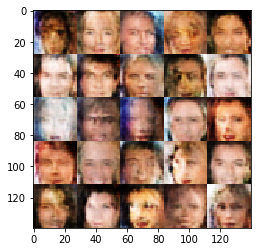

Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 2.9461


KeyboardInterrupt: 

In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.